In [12]:
"""
安装pySWATPlus
   SPOTPY
   mpi4py
   MS mpi

0、pySWATPlus 下载rar解压，用anaconda prompt界面cd到解压的文件夹，用pytohn setup.py install安装

一、TxtinoutReader
1.必须指定工作路径，否则工作路径会变成copy里的路径
2.必须使用绝对路径
3.网页教程的参数格式不对
4.改变参数，不指定行id时，用 None

二、FileReader
1.读取文件不指定index时，必须用None,不可省略
2.usecols省略的话，读取的df为空

三、定义SWAT函数给SPOTPY用时注意以下几点
1、SWAT模型的参数定义不要超过上下界，如(0, 1)用(0.001, 0.999)代替
2、用pySWATPlus定义函数给simulation用时，尽量把只修改一次文件的语句放函数外面
   例如， reader.set_beginning_and_end_year(2017, 2018)
         reader.set_warmup(1)
         reader.enable_object_in_print_prt("channel_sd", True, False, False, False)
   这些直接在root文件夹里手动改就行，不要写成代码，因为用mpiexec并行处理时，会导致文件被意想不到的修改
"""
%reset -f
import os
import pandas as pd
import numpy as np
import spotpy as sp
import shutil
import mpi4py
import sys
from pySWATPlus.TxtinoutReader import TxtinoutReader
from pySWATPlus.FileReader import FileReader
from matplotlib import pyplot as plt
from datetime import datetime
cwd = os.getcwd()

# 用pySWATPlus定义huron_swat函数

In [13]:
def huron_swat(reader, params):
    result = reader.copy_and_run(dir=os.path.join(cwd,'try'),
                                 params=params,
                                 show_output=False
                                 )
    # print(reader.root_folder)
    reader = FileReader(os.path.join(result, "channel_sd_day.txt"),
                        has_units = True,
                        index=None,
                        usecols=["mon", "day", "yr", "unit", "flo_out"],
                        filter_by={"unit": 1}
                        )
    res = reader.df
    res["Date"] = pd.to_datetime(pd.DataFrame({"year": res["yr"],
                                                 "month": res["mon"],
                                                 "day": res["day"]}))
    res.drop(columns=["mon", "day", "yr", "unit"], inplace=True)
    os.chdir(cwd) #改回当前路径
    return res

# 定义SPOTPY类

In [14]:
from spotpy.parameter import Uniform
class spot_swat():
    def __init__(self, TxtInOut_abspath):
        self.reader = TxtinoutReader(TxtInOut_abspath)
    
        self.params = [Uniform("lat_ttime",0.51, 179.0),
                       Uniform("can_max",0.01, 99.9),
                       Uniform("esco",0.01,0.99),
                       Uniform("epco",0.01, 0.99),
                       Uniform("cn3_swf",0.01, 0.99),
                       Uniform("perco",0.01, 0.99),
                       Uniform("pet_co",0.71, 1.29),
                       Uniform("latq_co",0.01, 0.99),
                       Uniform("cn_a",50.0, 70.0),
                       Uniform("cn_b",70.0, 80.0),
                       Uniform("cn_c",80.0, 90.0),
                       Uniform("cn_d",90.0, 99.0),
                       ]
    def parameters(self):
        return sp.parameter.generate(self.params)
    # par = [Uniform("lat_ttime",0.5, 180.0),
    #        Uniform("can_max",0.0, 100.0),
    #        Uniform("esco",0.0,.0),
    #        Uniform("epco",0.0, 1.0),
    #        Uniform("cn3_swf",0.0, 1.0),
    #        Uniform("perco",0.0, 1.0),
    #        Uniform("pet_co",0.7, 1.3),
    #        Uniform("latq_co",0.0, 1.0),
    #        Uniform("cn_a",50.0, 70.0),
    #        Uniform("cn_b",70.0, 80.0),
    #        Uniform("cn_c",80.0, 90.0),
    #        Uniform("cn_d",90.0, 100.0),
    #        ]
    def simulation(self, vector):
        par = np.array(vector)
        swat_params = {"hydrology.hyd":("name", [(None,"lat_ttime", par[0]),
                                                 (None,"can_max", par[1]),
                                                 (None,"esco", par[2]),
                                                 (None,"epco", par[3]),
                                                 (None,"cn3_swf", par[4]),
                                                 (None,"perco", par[5]),
                                                 (None,"pet_co", par[6]),
                                                 (None,"latq_co", par[7]),
                                                 ],
                                        ),
                       "cntable.lum":("description", [("Row_crops","cn_a", par[8]),
                                                      ("Row_crops","cn_b", par[9]),
                                                      ("Row_crops","cn_c", par[10]),
                                                      ("Row_crops","cn_d", par[11]),
                                                      ],
                                      ),
                       }
        sim = huron_swat(self.reader ,swat_params)
        return sim["flo_out"]
    
    def evaluation(self):
        obs = pd.read_csv(os.path.join(cwd,'TimeSeries\\04199000.csv'))
        obs["Date"] = pd.to_datetime(obs["Date"])
        obs = obs.loc[((obs["Date"] >= "2018-01-01") & (obs["Date"] <= "2020-12-31")),"Q"]
        return obs
    def objectivefunction(self, simulation, evaluation):
        objfun = sp.objectivefunctions.nashsutcliffe(evaluation, simulation)
        return objfun
    

In [15]:
proj_path = os.path.join(cwd, "TxtInOut")
spot_setup = spot_swat(proj_path)
spot_setup.reader.set_beginning_and_end_year(2017, 2020)
spot_setup.reader.set_warmup(1)
spot_setup.reader.enable_object_in_print_prt("channel_sd", True, False, False, False)
sampler = sp.algorithms.mc(spot_setup,
                           dbname="huron", 
                           dbformat="csv",
                           # parallel="mpc",
                           )
# print(describe(sampler))
sampler.sample(repetitions=3,
               # ngs=10,
               )

Initializing the  Monte Carlo (MC) sampler  with  3  repetitions
Starting the MC algorithm with 3 repetitions...
1 of 3, min objf=0.0109445, max objf=0.0109445, time remaining: 00:00:24
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'huron.csv' created.
2 of 3, min objf=-0.0463216, max objf=0.0109445, time remaining: 00:00:00
3 of 3, min objf=-0.0463216, max objf=0.0109445, time remaining: 23:59:26

*** Final SPOTPY summary ***
Total Duration: 137.24 seconds
Total Repetitions: 3
Minimal objective value: -0.0463216
Corresponding parameter setting:
lat_ttime: 10.2992
can_max: 28.9852
esco: 0.132387
epco: 0.884526
cn3_swf: 0.485917
perco: 0.57901
pet_co: 1.23601
latq_co: 0.955437
cn_a: 60.4813
cn_b: 73.7533
cn_c: 83.7808
cn_d: 90.6974
Maximal objective value: 0.0109445
Corresponding parameter setting:
lat_ttime: 25.9443
can_max: 65.5147
esco: 0.894261
epco: 0.944216
cn3_swf: 0.479974
perco: 0.915623
pet_co: 0.735439
latq_co: 0.819846
cn_a: 65.2422

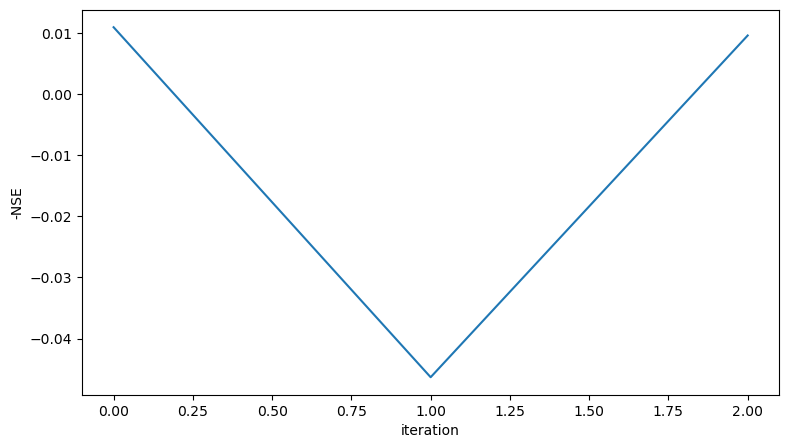

In [16]:
results = sp.analyser.load_csv_results("huron")
fig = plt.figure(1, figsize=(9,5))
plt.plot(results['like1'])
plt.xlabel("iteration")
plt.ylabel("-NSE")
plt.show()

In [17]:
# obs = pd.read_csv(os.path.join(cwd,'TimeSeries\\04199000.csv'))
# obs["Date"] = pd.to_datetime(obs["Date"])
# obs = obs.loc[((obs["Date"] >= "2018-01-01") & (obs["Date"] <= "2020-12-31")),"Q"]
# 
# copy_path = "D:\\Document\\5_Paper\\Uncertainty\\TidyData\\try\\tmpesiisrsz"
# reader = FileReader(os.path.join(copy_path, "channel_sd_day.txt"),
#                     has_units = True,
#                     index=None,
#                     usecols=["mon", "day", "yr", "unit", "flo_out"],
#                     filter_by={"unit": 1}
#                     )
# res = reader.df
# res["Date"] = pd.to_datetime(pd.DataFrame({"year": res["yr"],
#                                            "month": res["mon"],
#                                            "day": res["day"]}))
# res.drop(columns=["mon", "day", "yr", "unit"], inplace=True)